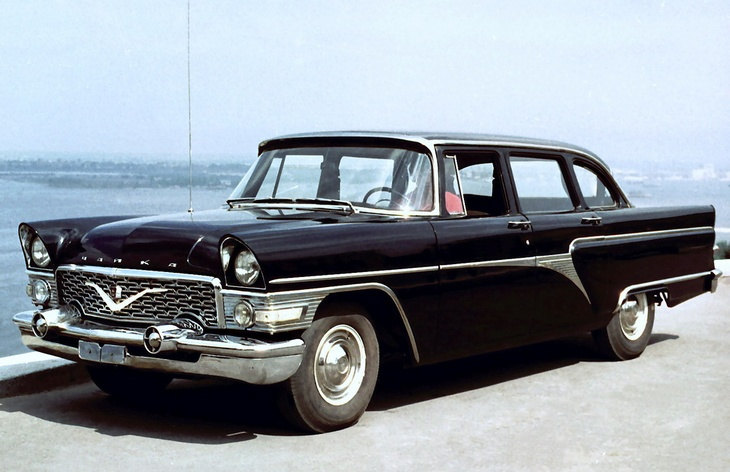

Задача проекта - создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.  
Заказчик - компания, которая занимается продажей автомобилей с пробегом в Москве.

Мы спарсили данные всех подержанных машин в городе Москва (+200 км), включая бренды тестовой выборки и несколько самых популряных

In [1]:
# импортируем библиотеки
import pandas as pd
pd.set_option('display.max_rows', 50)  
pd.set_option('display.max_columns', 50)

from pandas import Series
import ast
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter 

import warnings
warnings.filterwarnings("ignore")


from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import make_scorer

from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from category_encoders.ordinal import OrdinalEncoder

In [2]:
# определяем функции


'''функция для подсчета пропущенных значений и их процента от общего числа значений'''


def missing_table(df):
    mis_val = df.isnull().sum()
    percent = 100 * df.isnull().sum() / len(df)
    mis_table = pd.DataFrame({
        'Missing Values': mis_val,
        '% of Total Values': percent
    })
    return mis_table


'''функция, выводящая средние показатели: mean, median, mode'''


def mid_val(df, column):
    median = df[column].median()
    mode = df[column].mode()
    mean = df[column].mean()
    return display(
        pd.DataFrame({
            'Признак': column,
            'Медиана': median,
            'Среднее': mean,
            'Мода': mode
        }))


'''функция, выводящая все уникальные значения и их количество'''


def cat_values(df, column):
    display(pd.DataFrame(df[column].value_counts(dropna=True)))
    s = sns.catplot(x=column, kind="count", palette="Blues", data=df)
    s.set_xticklabels(rotation=90)


'''функция, возвращающая distplot для признака'''


def distplot(column):
    return sns.distplot(train[column], kde=False)



'''функция для вывода краткой описательной статистики'''


def desc_stat(column):
    minimum = train[column].min()
    maximum = train[column].max()
    IQR = train[column].quantile(0.75) - train[column].quantile(0.25)
    perc25 = train[column].quantile(0.25)
    perc75 = train[column].quantile(0.75)
    print(
        'Минимальное значение: {}'.format(minimum),
        '\nМаксимальное значение: {}'.format(maximum),
        '\n25-й перцентиль: {}'.format(perc25),
        '\n75-й перцентиль: {}'.format(perc75), '\nIQR: {}'.format(IQR),
        '\nГраницы выбросов: [{f}, {l}]'.format(f=perc25 - 1.5 * IQR,
                                                l=perc75 + 1.5 * IQR))


'''функция, определяющая границы выбросов'''


def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [5, 95])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return lower_bound, upper_bound


'''функция для опеределения средней стоимости автомобиля по категориям признака'''


def mean_price_by(column):
    return train.groupby([column])[['price'
                                    ]].mean().sort_values(['price'],
                                                          ascending=False)


'''функция, определяющая распределение средней стоимости автомобиля относительно его возраста'''


def price_by(column):
    return train.groupby(
        train[column])['price'].mean().to_frame().reset_index().sort_values(
            by=[column]).plot.line(x=column, y='price')


'''функция для построения графика зависимости от целевого признака'''


def price_plot(column):
    return sns.lmplot(x=column,
                      y="price",
                      hue="Руль",
                      data=train,
                      markers=["o", "x"],
                      palette="Set1")


'''функция, возвращающая график регрессии по средней стоимости'''


def lmplot_mean(column):
    return sns.lmplot(x=column, y="price", data=train, x_estimator=np.mean)


'''функция, определяющая среднюю абсолютную ошибку в процентах'''


def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true))


# отмечаем функцию для скоринга
mape_score = make_scorer(mape, greater_is_better=False)

In [3]:
train = pd.read_csv('find_cars.csv')
train.tail()

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня,price
39677,внедорожник 5 дв.,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/toua...,чёрный,"{'id': '2410132', 'name': 'R5 2.5TDI', 'availa...",Продам Туарег 2.5 R5 TDI. В птс 4 записи по фа...,2.5 LTR,174 N12,"{'cruise-control': True, 'esp': True, 'adaptiv...",дизель,https://avatars.mds.yandex.net/get-autoru-vos/...,210000,2006,"{'code': 'TOUAREG', 'name': 'Touareg', 'ru_nam...",Touareg,2.5d AT (174 л.с.) 4WD,5,RUB,2009,1101219762,"{'id': '2309941', 'displacement': 2461, 'engin...",ALLROAD_5_DOORS AUTOMATIC 2.5,автоматическая,EUROPEAN,"Владельцы,3 или более","Владение,4 года и 1 месяц","ПТС,Дубликат","Привод,полный","Руль,Левый","Состояние,Не требует ремонта","Таможня,Растаможен",880000
39678,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,бежевый,{'id': '0'},Все вопросы по телефону,1.8 LTR,160 N12,"{'cruise-control': True, 'asr': True, 'tinted-...",бензин,https://autoru.naydex.net/9Nr7cSB92/8fb7503HLO...,139000,2005,"{'code': 'PASSAT', 'name': 'Passat', 'ru_name'...",Passat,1.8 AT (160 л.с.),4,RUB,2008,1101565143,"{'id': '20100120', 'displacement': 1798, 'engi...",SEDAN AUTOMATIC 1.8,автоматическая,EUROPEAN,"Владельцы,3 или более",NaN,"ПТС,Дубликат","Привод,передний","Руль,Левый","Состояние,Не требует ремонта","Таможня,Растаможен",490000
39679,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,серебристый,{'id': '0'},Авто полностью обслужено.Заменены ремень грм.п...,1.8 LTR,125 N12,"{'engine-proof': True, 'electro-window-back': ...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,350000,1996,"{'code': 'PASSAT', 'name': 'Passat', 'ru_name'...",Passat,1.8 MT (125 л.с.) 4WD,4,RUB,1999,1093388938,"{'id': '20399848', 'displacement': 1781, 'engi...",SEDAN MECHANICAL 1.8,механическая,EUROPEAN,"Владельцы,3 или более","Владение,2 года и 5 месяцев","ПТС,Дубликат","Привод,полный","Руль,Левый","Состояние,Не требует ремонта","Таможня,Растаможен",270000
39680,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/polo...,белый,{'id': '0'},Полный комплектация 2019 май эксплуатация кл...,1.6 LTR,110 N12,"{'cruise-control': True, 'rear-camera': True, ...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,110000,2014,"{'code': 'POLO', 'name': 'Polo', 'ru_name': 'П...",Polo,1.6 AT (110 л.с.),4,RUB,2019,1102006055,"{'id': '20726520', 'displacement': 1598, 'engi...",SEDAN AUTOMATIC 1.6,автоматическая,EUROPEAN,"Владельцы,1 владелец",NaN,"ПТС,Оригинал","Привод,передний","Руль,Левый","Состояние,Не требует ремонта","Таможня,Растаможен",900000
39681,седан,VOLKSWAGEN,https://auto.ru/cars/used/sale/volkswagen/pass...,чёрный,{'id': '0'},"Продаю пассат 2011г. По ПТС два владельца, мно...",1.8 LTR,152 N12,{},бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,123000,2011,"{'code': 'PASSAT', 'name': 'Passat', 'ru_name'...",Passat,1.8 AMT (152 л.с.),4,RUB,2011,1102461090,"{'id': '7150232', 'displacement': 1798, 'engin...",SEDAN ROBOT 1.8,роботизированная,EUROPEAN,"Владельцы,2 владельца","Владение,5 месяцев","ПТС,Оригинал","Привод,передний","Руль,Левый","Состояние,Не требует ремонта","Таможня,Растаможен",825000


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39682 entries, 0 to 39681
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              39682 non-null  object
 1   brand                 39682 non-null  object
 2   car_url               39682 non-null  object
 3   color                 39682 non-null  object
 4   complectation_dict    39682 non-null  object
 5   description           39682 non-null  object
 6   engineDisplacement    39682 non-null  object
 7   enginePower           39682 non-null  object
 8   equipment_dict        39682 non-null  object
 9   fuelType              39682 non-null  object
 10  image                 39682 non-null  object
 11  mileage               39682 non-null  int64 
 12  modelDate             39682 non-null  int64 
 13  model_info            39682 non-null  object
 14  model_name            39682 non-null  object
 15  name                  39682 non-null

В обучающей выборке нет признака parsing_unixtime, который есть в тестовой

### Попробуем разделить наши признаки на категории:

* Категориальные: 'bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors','priceCurrency', 'vehicleTransmission', 'vendor', 'Состояние', 'Таможня', 'Владельцы', 'Владение', 'Привод', 'ПТС', 'Руль'
* Даты: 'modelDate', 'productionDate'
* Количественные: 'engineDisplacement', 'enginePower', 'mileage', 'price'
* Ссылки:'car_url', 'image'
* Смешанные: 'complectation_dict', 'description', 'equipment_dict', 'model_info', 'name', 'super_gen', 'vehicleConfiguration'

In [5]:
missing_table(train)

,Missing Values,% of Total Values
bodyType,0,0.000000
brand,0,0.000000
car_url,0,0.000000
color,0,0.000000
complectation_dict,0,0.000000
description,0,0.000000
engineDisplacement,0,0.000000
enginePower,0,0.000000
equipment_dict,0,0.000000
fuelType,0,0.000000


Прпоущенные значения замечены только в двух признаках, однако у нас они могут маскироваться под пустые строки, проверим  
А сейчас проверим датасет на наличие дубликатов

In [6]:
train['sell_id'].nunique() == len(train)

True

Дубликатов нет  
В признаках на русском языке значения содержат названия столбцов, избавимся от этого:

In [7]:
# сначала заполним 3 пропуска модой в признаке "Владельцы"

train['Владельцы'] = train['Владельцы'].fillna(train['Владельцы'].mode()[0])

In [8]:
# заполним пропущенные значения другой категорией в признаке "Владение"

train['Владение'] = train['Владение'].fillna('Владение,Не указано')

In [9]:
# определяем признаки, написанные на кириллице
cyrillic_cols = ['Владельцы','Владение','ПТС','Привод','Руль','Состояние','Таможня']

# чистим столбец
for col in cyrillic_cols:
    train[col] = train[col].apply(lambda x: x.split(',')[1])

# Целевая переменная

<AxesSubplot:xlabel='price'>

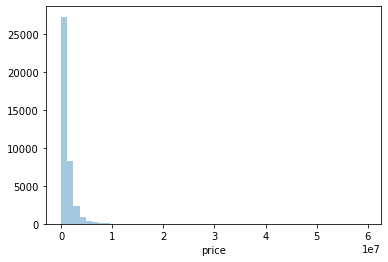

In [10]:
distplot('price')

<AxesSubplot:xlabel='price'>

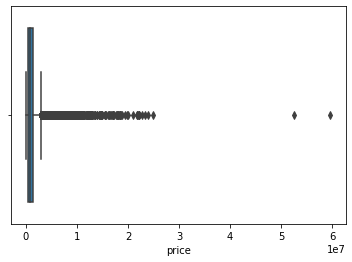

In [11]:
sns.boxplot(x=train["price"])

In [12]:
desc_stat('price')

Минимальное значение: 22000 
Максимальное значение: 59604352 
25-й перцентиль: 450000.0 
75-й перцентиль: 1449000.0 
IQR: 999000.0 
Границы выбросов: [-1048500.0, 2947500.0]


Целевая переменная распределена логнормально, имеются выбросы.  
Займемся ими позже, вместе с остальными числовыми признаками

# Даты

Я решила создать на основе признаков с годом выпуска и созданием модели - количественные признаки.  
Давность модели на рынке может говорить о высокой лояльности потребителей и, соответственно, высокому спросу, если модель существует давно. Новинки также могут говорить о высоком интересе к ней.  
Поэтому мы будем указывать возраст модели и возраст конкретного автомобиля вместо обозначения дат

## modelDate

In [13]:
# так как признак в числовом формате, просто отнимем значение от цифры нынешнего года

train['model_age'] = 2021 - train['modelDate']

<AxesSubplot:xlabel='model_age'>

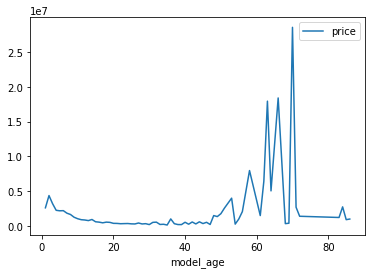

In [14]:
price_by('model_age')

Цена падает с ростом возраста модели, однако потом видны скачки, и снова спад.  
Попробуем посмотреть на признак иначе

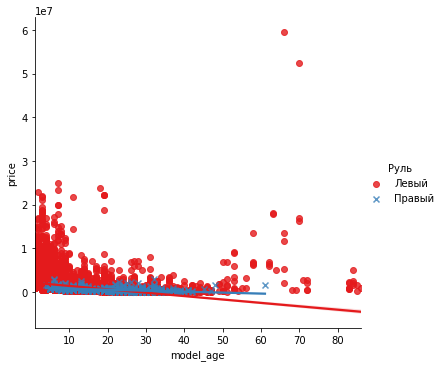

In [15]:
price_plot('model_age')

Тут уже видны, что скачки определены выбросами

In [16]:
# определим список для удаления столбцов
cols_to_drop = []

# удалим прежний признак
cols_to_drop.append('modelDate')

## productionDate

In [17]:
train['vehicle_age'] = 2021 - train['productionDate']

<AxesSubplot:xlabel='vehicle_age'>

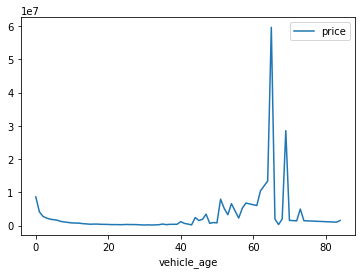

In [18]:
price_by('vehicle_age')

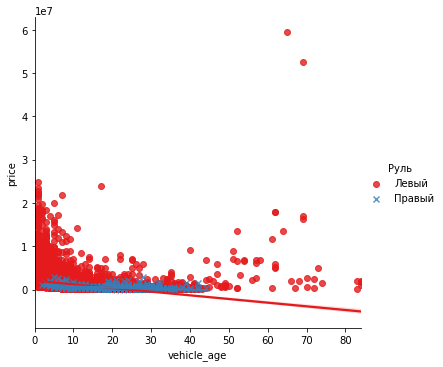

In [19]:
price_plot('vehicle_age')

In [20]:
# удаляем прежний признак

cols_to_drop.append('productionDate')

Ожидаемо - цены с увеличением возраста падают, но интересно, что для праворульных машин это не такой значимый фактор, как для леворульных

# Количественные признаки

## engineDisplacement

Тут у нас указан объем двигателя. К сожалению, я не нашла значение приставки LTR.  
Надо понять присутствует ли эта приставка везде

In [21]:
engine_words = train['engineDisplacement'].apply(lambda x: x.split(' ')[1])
engine_words.value_counts()

LTR    39682
Name: engineDisplacement, dtype: int64

Убираем все приставки "LTR", и преобразуем признак в форму вещественных чисел

In [22]:
train['engineDisplacement'] = train['engineDisplacement'].apply(lambda x: x.split(' ')[0])

In [23]:
# Замена объема двигателя электрокаров на 0

train['engineDisplacement'] = train['engineDisplacement'].replace('',0, regex=True)
train['engineDisplacement']=train['engineDisplacement'].astype('float')

<AxesSubplot:xlabel='engineDisplacement'>

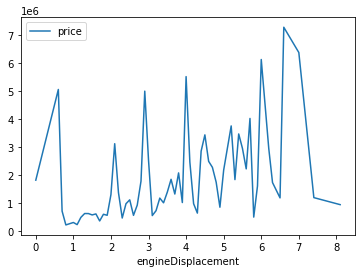

In [24]:
price_by('engineDisplacement')

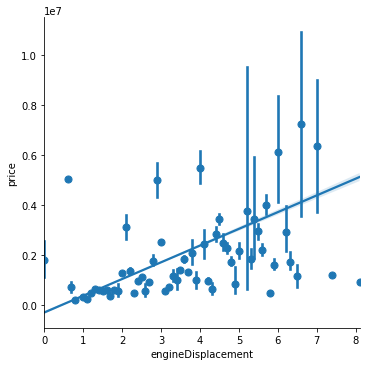

In [25]:
lmplot_mean("engineDisplacement")

Имеются выбросы  
Прямо пропорциональная зависимость стоимости автомобиля с объемом двигателя

## enginePower

In [26]:
engine_p = train['enginePower'].apply(lambda x: x.split(' ')[1])
engine_p.value_counts()

N12    39682
Name: enginePower, dtype: int64

In [27]:
# Приставка N12 также везде, избавимся от нее и переведем в формат целых чисел

train['enginePower'] = train['enginePower'].apply(lambda x: x.split(' ')[0]).astype('int64')

<AxesSubplot:xlabel='enginePower'>

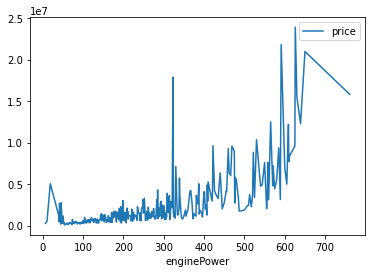

In [28]:
price_by('enginePower')

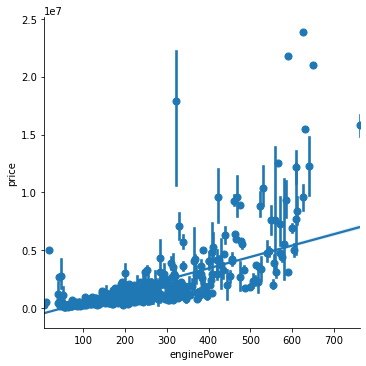

In [29]:
lmplot_mean("enginePower")

Также есть выбросы и прямая зависимость со стоимостью автомобиля

## mileage

<AxesSubplot:xlabel='mileage'>

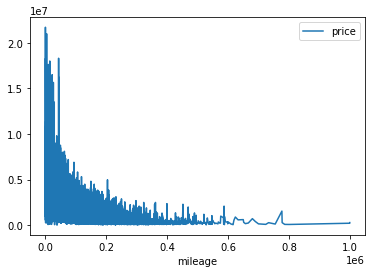

In [30]:
price_by('mileage')

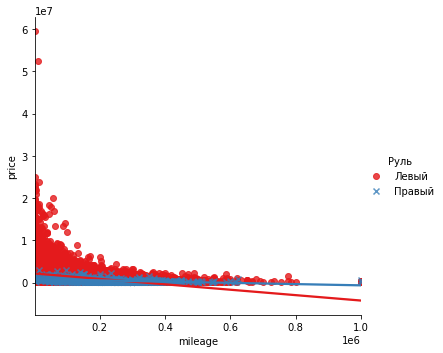

In [31]:
price_plot('mileage')

Логнормальное распределение признака, обратная зависимость с целевой переменной  
Есть выбросы

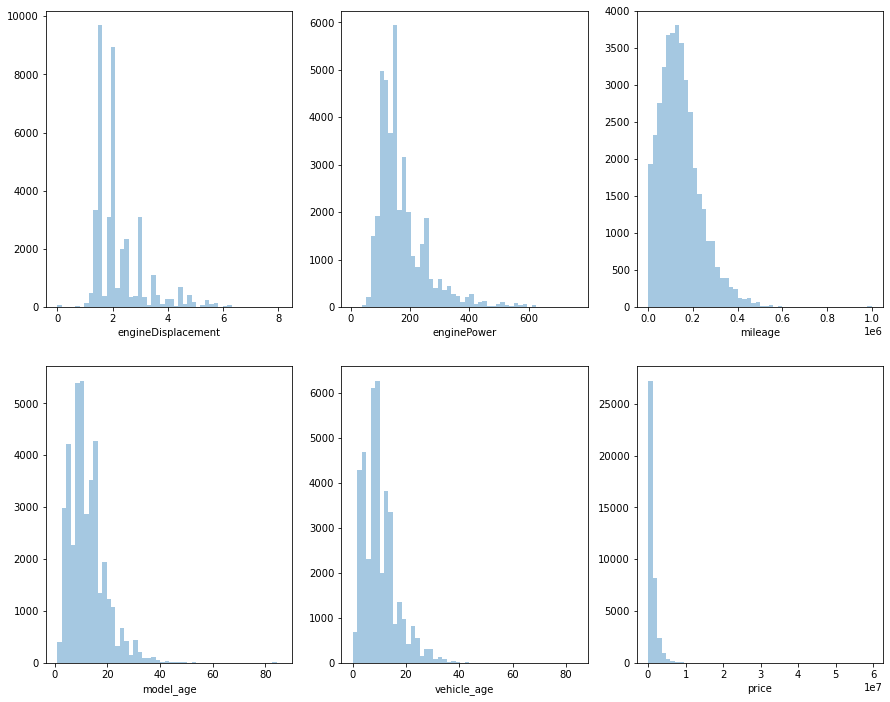

In [32]:
# Обозначим список
num_cols = ['engineDisplacement', 'enginePower', 'mileage', 'model_age', 'vehicle_age', 'price']

#Посмотрим распределение данных
fig, axes = plt.subplots(2,3, figsize=(15, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

In [33]:
# Удалим выбросы в числовых признаках
for col in ['engineDisplacement', 'enginePower', 'mileage', 'model_age', 'vehicle_age']:
    d = outliers_iqr(train[col])
    train = train.loc[train[col].between(d[0], d[1])]
    
# прологарифмируем целевую переменную
train['price'] = np.log(train['price'] + 1)

Кратко рассмотрим, как относительно стоимости распределилсь признаки

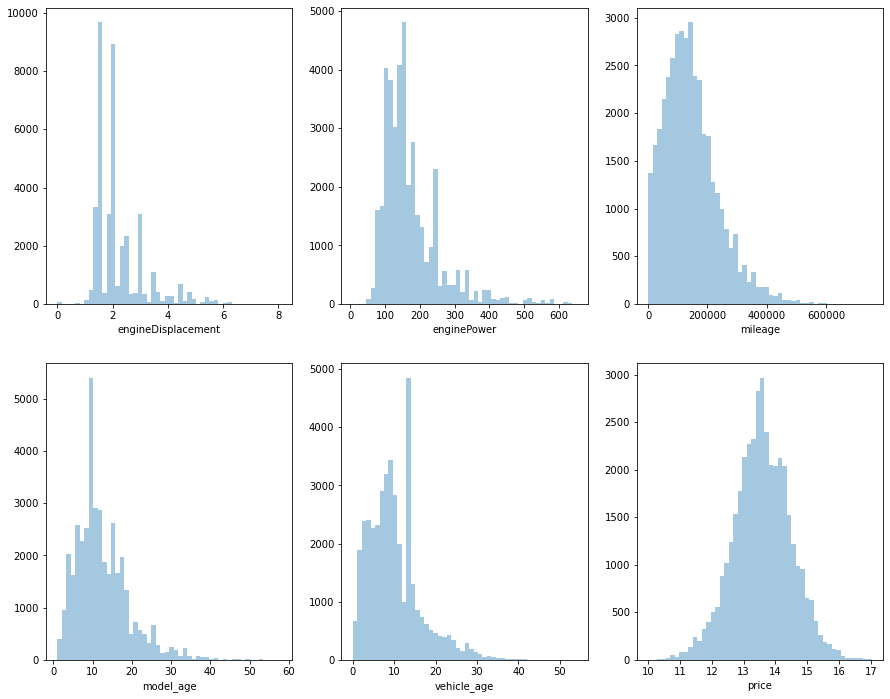

In [34]:
#Посмотрим распределение данных
fig, axes = plt.subplots(2,3, figsize=(15, 12))
for col, i in zip(num_cols, range(8)):
    sns.distplot(train[col], kde=False, ax=axes.flat[i])

<AxesSubplot:xlabel='vehicle_age'>

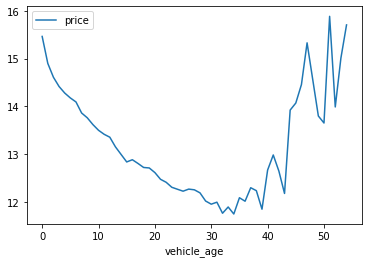

In [35]:
price_by('vehicle_age')

<AxesSubplot:xlabel='enginePower'>

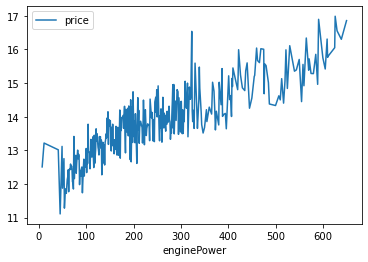

In [36]:
price_by('enginePower')

Распределение c удалениием выбросов стало более плавным  

# Категориальные признаки

## bodytype

In [37]:
train['bodyType'].value_counts(dropna=False)

седан                      14091
внедорожник 5 дв.          13970
хэтчбек 5 дв.               4099
лифтбек                     1752
универсал 5 дв.             1447
компактвэн                  1052
минивэн                     1001
хэтчбек 3 дв.                793
купе                         670
пикап двойная кабина         231
фургон                       134
купе-хардтоп                 108
внедорожник 3 дв.             94
кабриолет                     76
родстер                       70
седан-хардтоп                 13
микровэн                      10
хэтчбек 4 дв.                  5
тарга                          5
пикап полуторная кабина        2
пикап одинарная кабина         2
внедорожник открытый           2
лимузин                        2
седан 2 дв.                    1
Name: bodyType, dtype: int64

Вопрос стоит ли менять формат и, допустим, удалить количество дверей в названии кузова, если они все равно указаны в отдельном столбце.  
С другой стороны, в тестовой выборе они в таком же формате, плюс, я в машинах совсем не разбираюсь, так что оставлю как есть.

## brand

,brand
VOLKSWAGEN,3255
KIA,3254
BMW,3151
HYUNDAI,3086
MERCEDES,3019
NISSAN,2770
TOYOTA,2765
AUDI,2165
CHEVROLET,1839
SKODA,1837


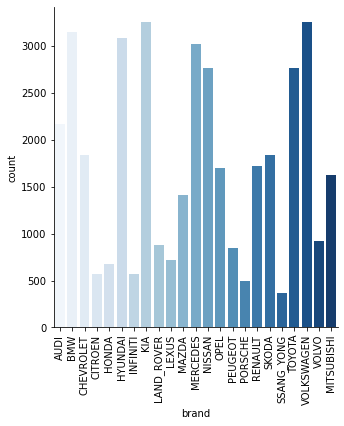

In [38]:
cat_values(train, 'brand')

Если не учитывать бренды, не включенные в тестовую выборку, распределение примерно такое же.  
Свыше 3000 объявлений у VOLKSWAGEN, KIA, BMW, HYUNDAI

In [39]:
mean_price_by('brand')

,price
brand,
PORSCHE,14.864432
LEXUS,14.507358
MERCEDES,14.362991
LAND_ROVER,14.286988
BMW,14.162849
INFINITI,14.070785
TOYOTA,13.894262
AUDI,13.721646
KIA,13.572305


В среднем самая дорогая марка - PORSCHE, самая дешевая - PEUGEOT

## color

In [40]:
train['color'].value_counts()

чёрный         10812
белый           7817
серый           4941
серебристый     4491
синий           3705
красный         2152
коричневый      1920
зелёный          954
бежевый          937
голубой          553
жёлтый           300
золотистый       272
пурпурный        267
оранжевый        256
фиолетовый       244
розовый            9
Name: color, dtype: int64

За исключением нескольких примеров, распределение по цветам такое же как в тестовой

In [41]:
mean_price_by('color')

,price
color,
коричневый,13.917653
чёрный,13.833943
белый,13.788953
оранжевый,13.632357
серый,13.503742
синий,13.415836
жёлтый,13.336605
бежевый,13.320028
голубой,13.281907


Интересно, что черные автомобили лидируют и по популярности и по цене в среднем, розовый аналогично в аутсайдерах  
А вот оранжевый,видимо, за счет малого количества выделяется средней ценой

## fuelType

,fuelType
бензин,32998
дизель,6392
гибрид,166
электро,64
газ,10


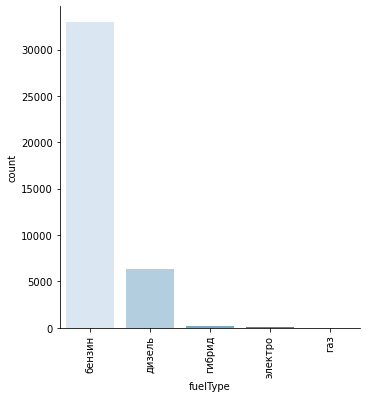

In [42]:
cat_values(train, 'fuelType')

Бензиновые двигатели, как и ожидалось, самые популярные

In [43]:
mean_price_by('fuelType')

,price
fuelType,
дизель,14.205802
гибрид,14.083135
электро,13.764472
бензин,13.456458
газ,13.247727


Машины на газу - самые дешевые и самые не популярные, самые дорогие автомобили - на дизеле  

## model_name

In [44]:
train['model_name'].value_counts()

Octavia          941
Solaris          865
Rio              821
Astra            775
5 серии          714
                ... 
200SX              1
Voltz              1
S-10 Pickup        1
Otti               1
SLK-Класс AMG      1
Name: model_name, Length: 779, dtype: int64

Самые популярные модели принадлежат маркам SKODA, HYUNDAI, KIA, OPEL, BMW соответственно

## numberOfDoors

Я переместила этот признак в категориальные, так как не смогла ответить насколько лучше 5-дверная машина 2-дверной.  
Плюс, это действительно больше категориальный признак, потому что каждый выбирает нужную ему, и пять дверей не означает, что машина будет медленнее/тяжелее машины с четырьмя дверьми, или определенно лучше чем 3-дверная

,numberOfDoors
5,22891
4,14848
3,946
2,945


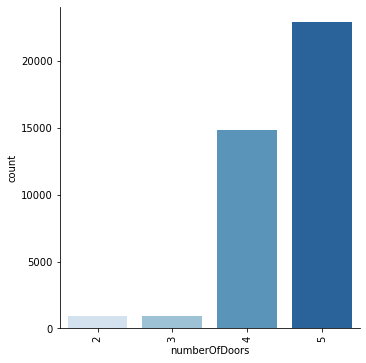

In [45]:
cat_values(train, 'numberOfDoors')

In [46]:
mean_price_by('numberOfDoors')

,price
numberOfDoors,
2,14.091361
5,13.735225
4,13.359200
3,12.795025


Видим, что незначительно, но в среднем, 2-дверные и 5-дверные машины дороже других вариаций

## priceCurrency

In [47]:
train['priceCurrency'].value_counts()

RUB    39630
Name: priceCurrency, dtype: int64

Так как тут всего один вариант значения, удалим колонку как бесполезную для нас

In [48]:
cols_to_drop.append('priceCurrency')

## vehicleTransmission

,vehicleTransmission
автоматическая,22717
механическая,10246
роботизированная,3669
вариатор,2998


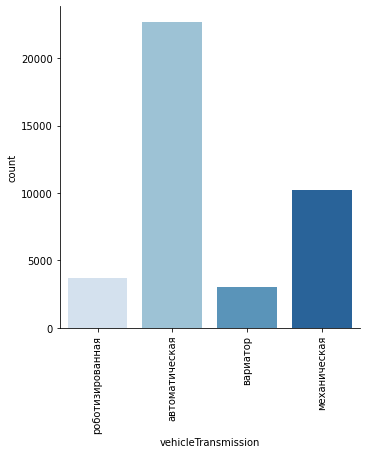

In [49]:
cat_values(train, 'vehicleTransmission')

Автоматические и механические коробки, ожидаемо, лидеры на рынке

In [50]:
mean_price_by('vehicleTransmission')

,price
vehicleTransmission,
роботизированная,13.904705
автоматическая,13.849522
вариатор,13.755487
механическая,12.816317


В среднем машины с механической коробкой передач дешевле в 3 раза чем машины с автоматической.  
Возможно, еще и благодаря низкой цене, механическая коробка среди лидеров. 

## vendor

,vendor
EUROPEAN,20563
JAPANESE,10520
KOREAN,6708
AMERICAN,1512
RUSSIAN,327


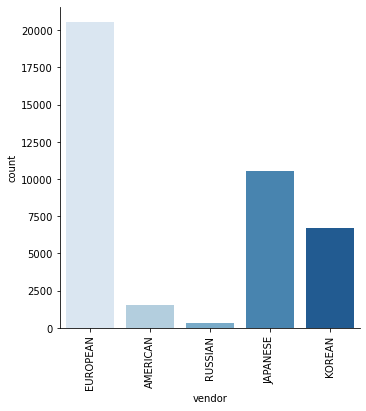

In [51]:
cat_values(train, 'vendor')

In [52]:
mean_price_by('vendor')

,price
vendor,
EUROPEAN,13.670115
JAPANESE,13.586311
KOREAN,13.501910
AMERICAN,12.864595
RUSSIAN,12.667375


Машины европейских и японских производителей среди лидеров как по распространенности, так и по дороговизне машин  
Интересно, что в тестовой выборке только производители этих двух лидеров

##  Состояние

In [53]:
train['Состояние'].value_counts()

Не требует ремонта    39630
Name: Состояние, dtype: int64

In [54]:
# Всего один вариант значения, избавляемся от признака

cols_to_drop.append('Состояние')

## Таможня

In [55]:
train['Таможня'].value_counts()

Растаможен    39630
Name: Таможня, dtype: int64

In [56]:
# По аналогии так же удаляю этот столбец

cols_to_drop.append('Таможня')

## Владельцы

,Владельцы
3 или более,15921
1 владелец,13007
2 владельца,10702


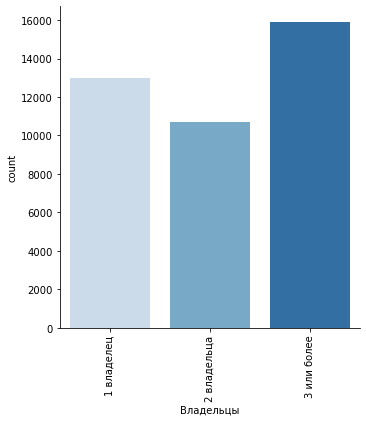

In [57]:
cat_values(train, 'Владельцы')

In [58]:
mean_price_by('Владельцы')

,price
Владельцы,
1 владелец,14.029385
2 владельца,13.680518
3 или более,13.146271


Интересно, что количество владельцев не сильно влияет на среднюю стоимость машины

## Владение

На результат признак самую малость, но все же влияет положительно, оставим как есть

In [59]:
mean_price_by('Владение')

,price
Владение,
20 лет и 10 месяцев,15.754252
22 года и 8 месяцев,15.068274
19 лет и 2 месяца,14.648420
20 лет и 3 месяца,14.508658
16 лет и 12 месяцев,14.375127
...,...
39 лет,11.211618
20 лет и 4 месяца,10.915107
19 лет и 12 месяцев,10.878066


## Привод

,Привод
передний,21582
полный,14734
задний,3314


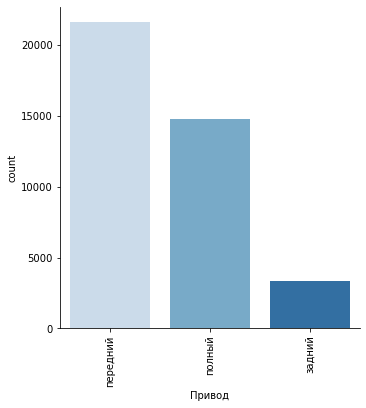

In [60]:
cat_values(train, 'Привод')

In [61]:
mean_price_by('Привод')

,price
Привод,
полный,14.154782
задний,13.650555
передний,13.177480


Разница небольшая, но всё же есть.
Интересно, что машины с задним приводом в целом чуть дороже машин с передним.  
Коробка передач и главный редуктор у таких машин больше по размерам, чем у переднеприводных.  
А популярность переднего привода объясняется тем, что он проще и потому безопаснее

## ПТС

,ПТС
Оригинал,34814
Дубликат,4816


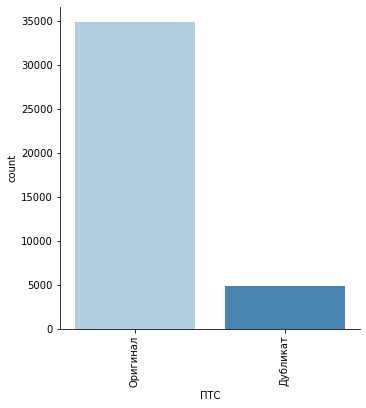

In [62]:
cat_values(train, 'ПТС')

In [63]:
mean_price_by('ПТС')

,price
ПТС,
Оригинал,13.647459
Дубликат,13.095566


Разница не такая большая, как я ожидала, но всё же оригинал дороже

## Руль

,Руль
Левый,38658
Правый,972


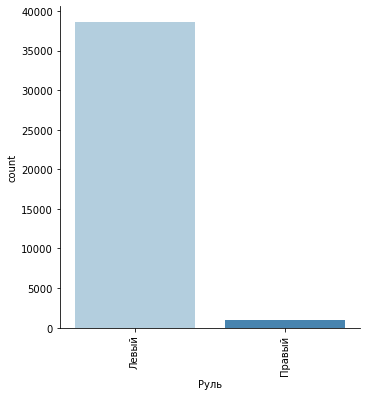

In [64]:
cat_values(train, 'Руль')

In [65]:
mean_price_by('Руль')

,price
Руль,
Левый,13.600968
Правый,12.762011


Леворульные машины в среднем дороже, но как мы видели, они более чувствительны к количественным признакам в отношении цены, чем праворульные  
По всей видимости, за счет меньшего выбора, любители праворульных лояльнее

# Ссылки

Ссылки нам не понадобятся, удаляем их

In [66]:
cols_to_drop.append('car_url')
cols_to_drop.append('image')

# Смешанные признаки

## complectation_dict

In [67]:
train['complectation_dict'].value_counts().head(2)

{'id': '0'}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                31811
{'id': '20913628', 'name': 'Style', 'available_options': ['cruise-control', 'multi-wheel', 'heated-wash

Тут очень много пустых словарей - {'id': '0'} В непустых значениях есть словарь available-options, который в некоторых случаях повторяет то, что есть в equipment_dict  
Поэтому этот признак мы сбросим

In [68]:
train.loc[train['complectation_dict'] == "{'id': '0'}", 'complectation_dict'] = np.nan

In [69]:
train['complectation_temp'] = train['complectation_dict'].notnull()
train['complectation_dict'] = train['complectation_temp'].map({False:0, True: 1})

cols_to_drop.append('complectation_temp')

## description

Прочитав пару статей на mag.auto.ru я узнала, что люди обращают внимание на то, кто продавец. Еще указано, что "буквально у каждого из них есть свой отдел trade-in"  

Можно будет на основе этого создать признак, который покажет, явлется ли продавец дилером или нет

[Ссылка на статью](https://mag.auto.ru/article/dreamcarowner/)

## equipment_dict

In [70]:
train['equipment_dict'][0]

"{'cruise-control': True, 'esp': True, 'aux': True, 'usb': True, 'electro-window-front': True, 'light-sensor': True, 'multi-wheel': True, 'hcc': True, 'collision-prevention-assist': True, 'navigation': True, 'computer': True, 'apple-carplay': True, 'keyless-entry': True, 'roof-rails': True, 'android-auto': True, 'wheel-power': True, 'alarm': True, 'lock': True, 'fabric-seats': True, 'steering-wheel-gear-shift-paddles': True, 'electro-mirrors': True, 'alloy-wheel-disks': True, 'ptf': True, 'leather-gear-stick': True, 'start-button': True, 'feedback-alarm': True, 'rain-sensor': True, 'remote-engine-start': True, 'audiosystem-cd': True, 'dark-interior': True, 'wheel-heat': True, 'electro-trunk': True, 'led-lights': True, 'abs': True, 'bluetooth': True, 'front-seats-heat': True, 'wheel-leather': True, 'wheel-configuration1': True, 'immo': True, 'climate-control-2': True, 'park-assist-r': True, 'black-roof': True}"

Признак хранит в себе множество разных опций, и при этом является словарем-строкой.  
Я преобразую значения признака в список, чтобы можно было впоследствии создать новые признаки

In [71]:
train['equipment_dict'] = train['equipment_dict'].apply(lambda x: x[1:-1])
train['equipment_dict'] = train['equipment_dict'].apply(lambda x: x.replace("'", "\""))
train['equipment_dict'] = train['equipment_dict'].apply(lambda x: x.replace(": True", ""))
train['equipment_dict'] = train['equipment_dict'].apply(lambda x: x.split(', '))

5 самых популряных опций комплектации в тестовой и тренировочной выборке совпадают, сделаем на их основе dummy-переменные

In [72]:
e_list = ['"lock"', '"abs"', '"electro-mirrors"', '"computer"','"airbag-driver"']

In [73]:
train['new_equip'] = train['equipment_dict'].apply(lambda x: [a for a in x if a in e_list])

In [74]:
train['equipment_dict'] = train['equipment_dict'].apply(lambda x: 0 if x==[''] else 1)

## model_info

In [75]:
train['model_info'][0]

"{'code': 'Q3', 'name': 'Q3', 'ru_name': 'Ку3', 'morphology': {}, 'nameplate': {'code': '', 'name': '', 'semantic_url': ''}}"

Ячейки не содержат ничего кроме названия модели, которая уже представлена в другой колонке  
Удаляем признак

In [76]:
cols_to_drop.append('model_info')

## name

In [77]:
train['name'][0]

'35 TFSI 1.4 AMT (150 л.с.)'

Признак дублирует значения engineDisplacement и enginePower, удаляем его

In [78]:
cols_to_drop.append('name')

## super_gen

In [79]:
train['super_gen'][0]

"{'id': '21666861', 'nameplate': '35 TFSI', 'displacement': 1395, 'engine_type': 'GASOLINE', 'gear_type': 'FORWARD_CONTROL', 'transmission': 'ROBOT', 'power': 150, 'power_kvt': 110, 'human_name': '35 TFSI 1.4 AMT (150 л.с.)', 'acceleration': 9.2, 'clearance_min': 170, 'fuel_rate': 5.9}"

Тут также признак является собирательным. Но есть новое значение fuel_rate, проверим что в электрокарах

In [80]:
train['super_gen'][2017]

"{'id': '20471790', 'displacement': 0, 'engine_type': 'ELECTRO', 'gear_type': 'FORWARD_CONTROL', 'transmission': 'AUTOMATIC', 'power': 109, 'power_kvt': 80, 'human_name': 'Electro AT (81 кВт)', 'acceleration': 11.9, 'clearance_min': 156, 'electric_range': 175, 'battery_capacity': 24}"

In [81]:
train['super_gen'] = train['super_gen'].apply(lambda x: x.replace("'", "\""))
train['super_gen'] = train['super_gen'].apply(lambda x: ast.literal_eval(x))

При создании новых признаков проверим необходимость обозначения fuel_rate и battery_capacity

## vehicleConfiguration

In [82]:
train['vehicleConfiguration'][0]

'ALLROAD_5_DOORS ROBOT 1.4'

Признак является собирательным. Вся эта информация у нас есть, удаляем

In [83]:
cols_to_drop.append('vehicleConfiguration')

# Feature Engineering

## dealer

Для того, чтобы создать новый признак, нужно найти в столбце description все упоминания трейд-ин  
Проверим заодно, поможет ли новый признак

In [84]:
dealer_list = []
for index, row in train['description'].items():
    if 'trade-in' in row:
        dealer_list.append(index)
    elif 'TRADE_IN' in row:
        dealer_list.append(index)
    elif 'Trade-in' in row:
        dealer_list.append(index)
    elif 'трейд-ин' in row:
        dealer_list.append(index)
    elif 'Трейд-ин' in row:
        dealer_list.append(index)
    elif 'ТРЕЙД-ИН' in row:
        dealer_list.append(index)

In [85]:
train['dealer'] = 0
for n, i in enumerate(dealer_list):
    train.loc[i, 'dealer'] = 1

In [86]:
# теперь можно удалить признак description

cols_to_drop.append('description')

## dummies

Создадим на основе списков в признаке equipment_dict dummy-переменные

In [87]:
dummies = pd.get_dummies(train['new_equip'].apply(
    pd.Series).stack()).sum(level=0)
dummies = dummies.rename(columns=lambda x: x.replace('"', ''))
dummies.isna().sum()

abs                0
airbag-driver      0
computer           0
electro-mirrors    0
lock               0
dtype: int64

In [88]:
train = pd.concat([train, dummies], axis=1)

In [89]:
train = train.fillna(0)

In [90]:
cols_to_drop.append('new_equip')

## fuel_rate и battery_capacity

In [91]:
train['fuel_rate'] = train['super_gen'].apply(lambda x: x.get('fuel_rate', 0))
train['battery_capacity'] = train['super_gen'].apply(lambda x: x.get('battery_capacity', 0))

In [92]:
cols_to_drop.append('super_gen')

# Значимость переменных

<AxesSubplot:>

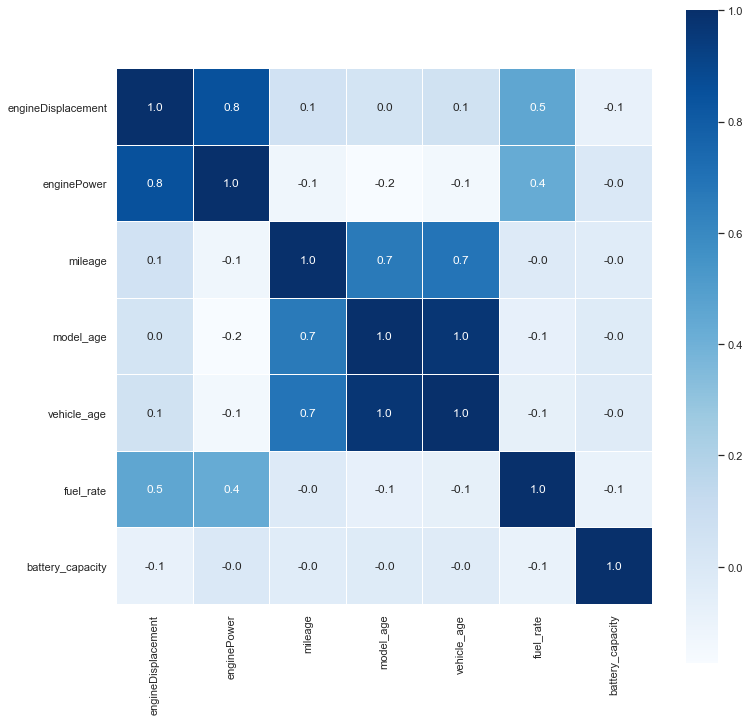

In [93]:
num_cols = [
    'engineDisplacement', 'enginePower', 'mileage', 'model_age', 'vehicle_age',
    'fuel_rate', 'battery_capacity'
]

sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
sns.heatmap(train[num_cols].corr(),
            square=True,
            annot=True,
            fmt=".1f",
            linewidths=0.1,
            cmap="Blues")

Text(0.5, 0, 'F-value')

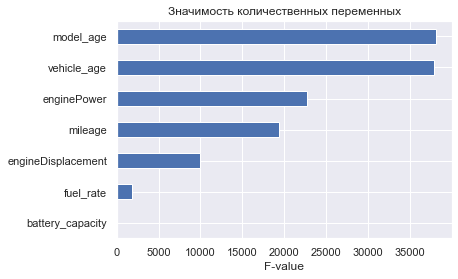

In [94]:
# для оценки непрерывных значений будем использовать функцию f_regression

imp_num = Series(f_regression(train[num_cols], train['price'])[0],
                 index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')
plt.title('Значимость количественных переменных')
plt.xlabel('F-value')

Кандидаты на удаление: engineDisplacement,vehicle_age  
Однако удаление этих файлов негативно сказывается на метрике

In [95]:
cat_cols = [
    'bodyType', 'brand', 'color', 'fuelType', 'model_name', 'numberOfDoors',
    'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'Привод'
]

bin_cols = [
    'complectation_dict', 'equipment_dict', 'ПТС', 'Руль', 'dealer', 'abs',
    'airbag-driver', 'computer', 'electro-mirrors', 'lock'
]

In [96]:
cols_to_drop.append('sell_id')
train = train.drop(cols_to_drop, axis=1)

In [97]:
for col in ['lock', 'abs', 'electro-mirrors', 'computer','airbag-driver']:
    train[col] = train[col].astype('int64')
    
train.tail()

,bodyType,brand,color,complectation_dict,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,model_name,numberOfDoors,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,price,model_age,vehicle_age,dealer,abs,airbag-driver,computer,electro-mirrors,lock,fuel_rate,battery_capacity
39677,внедорожник 5 дв.,VOLKSWAGEN,чёрный,1,2.5,174,1,дизель,210000,Touareg,5,автоматическая,EUROPEAN,3 или более,4 года и 1 месяц,Дубликат,полный,Левый,13.687678,15,12,0,1,1,1,1,1,9.9,0.0
39678,седан,VOLKSWAGEN,бежевый,0,1.8,160,1,бензин,139000,Passat,4,автоматическая,EUROPEAN,3 или более,Не указано,Дубликат,передний,Левый,13.102163,16,13,0,1,1,1,1,1,8.2,0.0
39679,седан,VOLKSWAGEN,серебристый,0,1.8,125,1,бензин,350000,Passat,4,механическая,EUROPEAN,3 или более,2 года и 5 месяцев,Дубликат,полный,Левый,12.506181,25,22,0,1,1,0,0,1,9.4,0.0
39680,седан,VOLKSWAGEN,белый,0,1.6,110,1,бензин,110000,Polo,4,автоматическая,EUROPEAN,1 владелец,Не указано,Оригинал,передний,Левый,13.710151,7,2,0,0,0,0,0,0,5.9,0.0
39681,седан,VOLKSWAGEN,чёрный,0,1.8,152,0,бензин,123000,Passat,4,роботизированная,EUROPEAN,2 владельца,5 месяцев,Оригинал,передний,Левый,13.623140,10,10,0,0,0,0,0,0,7.1,0.0


In [98]:
encode_cols = cat_cols+bin_cols
oe = OrdinalEncoder()
train[encode_cols] = oe.fit_transform(train[encode_cols])

Text(0.5, 1.0, 'Significance of cat variables')

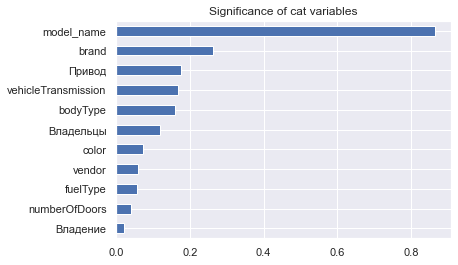

In [99]:
imp_cat = pd.Series(mutual_info_regression(train[cat_cols],
                                        train['price'],
                                        discrete_features=True),
                    index=train[cat_cols].columns)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')
plt.title('Significance of cat variables')

Видим, как значимо именно название модели

Text(0.5, 1.0, 'Significance of ord variables')

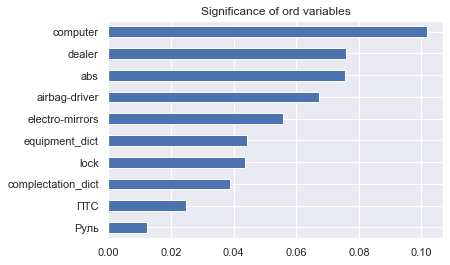

In [100]:
imp_ord = pd.Series(mutual_info_regression(train[bin_cols],
                                        train['price'],
                                        discrete_features=True),
                    index=train[bin_cols].columns)
imp_ord.sort_values(inplace=True)
imp_ord.plot(kind='barh')
plt.title('Significance of ord variables')

<AxesSubplot:>

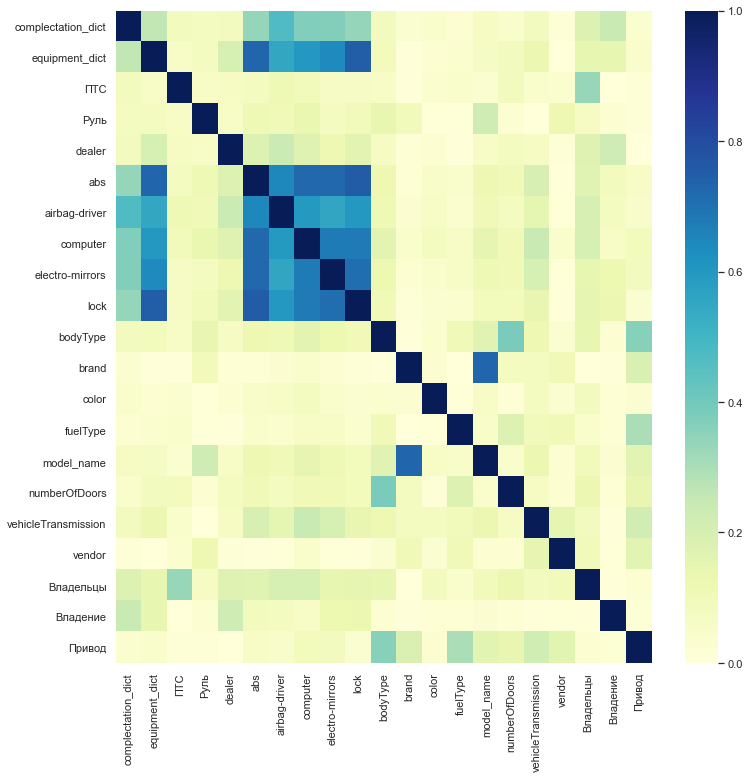

In [101]:
plt.subplots(figsize=(12, 12))
sns.heatmap(train[bin_cols + cat_cols].corr(method='spearman').abs(),
            vmin=0,
            vmax=1,
            cmap="YlGnBu")

Рада, что сгенерированные признаки оказались полезными, computer стоит выше изначальных признаков  
Приступим к обучению модели